# <span style='color:deepskyblue'> Cosmology MCMC notebook </span>

## <span style='color:deepskyblue'>Preliminaries</span>

In [138]:
# Install required packages (if not available on server)
%pip install scipy
%pip install getdist

import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as integrate

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## <span style='color:deepskyblue'> The $\Lambda$CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{100 \text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [139]:
# Physical constants
PARSEC = 3.086e16
Mpc    = PARSEC * 10**6
c      = 2.998e5  # speed of light in km/s
'''I changed the global variables, and put H_0 into the HUbble Rate function. 
It was suggested by ChatGPT, so I could then use it in the MCMC'''

# Hubble rate
def HubbleRate(z, h, omega_l, omega_m):
    # Returns Hubble rate H(z) in km/s/Mpc for a given set of parameters.
    H_0 = h * 100.0  # Freed up 'h' from the global, as I mentioned

    return H_0 * np.sqrt(omega_l + omega_m * (1 + z)**3 + (1 - omega_l - omega_m) * (1 + z)**2)

##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [140]:
c = 2.998e5 # speed of light

# Luminosity distance function
def dL(z, h, omega_m, omega_l):
    """ Computes the luminosity distance in parsecs (or Mpc, depending on scaling)
    based on Freedman-Lemaître–Robertson–Walker cosmology."""
    
    # Insted of a global function that I initially used
    H_0 = h * 100.0

    omega_k = 1. - omega_l - omega_m # from the cell with formulas above

    '''I had some troubles with calculating d_z when I tried to use Hubble function.
    Then Rens suggested to directly put the formula, that's what I did'''
    d_z = integrate.quad(lambda Z: 1. / np.sqrt(omega_l + omega_m * (1. + Z)**3 + (1. - omega_l - omega_m) * (1. + Z)**2), 0., z)[0]


    '''Also I tried to use return after each case, but it didn't work for some reason.
    So I used func, which I then used to return the value'''
    if omega_k > 0.:
        # open geometry
        func = 1 / np.sqrt(omega_k) * np.sinh(np.sqrt(omega_k) * d_z)
    elif omega_k < 0.:
        # closed geometry
        func = 1. / np.sqrt(-omega_k) * np.sin(np.sqrt(-omega_k) * d_z)
    else:
        # flat geometry
        func = d_z

    return c * (1. + z) / H_0 * func

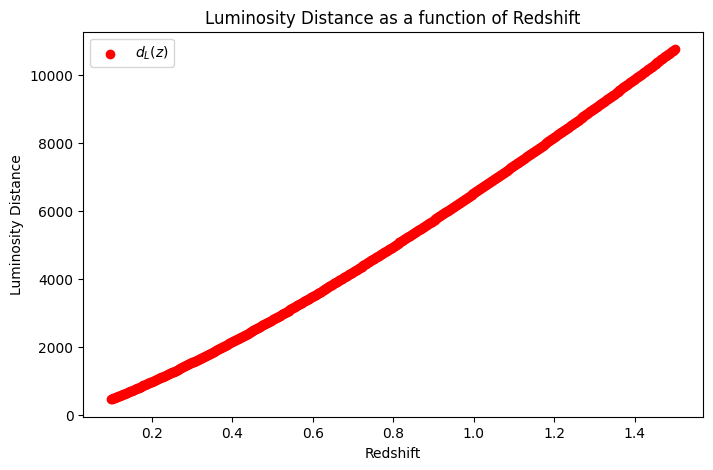

In [141]:
omega_l = 0.7
omega_m = 0.3
h = 0.71

#Values for redshift range, which I use for the plot and later for mcmc
zs = np.linspace(0.1, 1.5, 580)
dLs = [dL(z, h, omega_m, omega_l) for z in zs] # Fran told me to add this function to make it work

#The plot
plt.figure(figsize=(8, 5))
plt.scatter(zs, dLs, label=r'$d_L(z)$', color='red')
plt.xlabel(r'Redshift')
plt.ylabel(r'Luminosity Distance')
plt.title('Luminosity Distance as a function of Redshift')
plt.legend()
plt.show()

In [142]:
# To plot graphs, suggested by Rens
def dL_modulus(z, h, omega_m, omega_l):
    return 5 * (np.log10(dL(z, h, omega_m, omega_l) * 1e6 / 10))

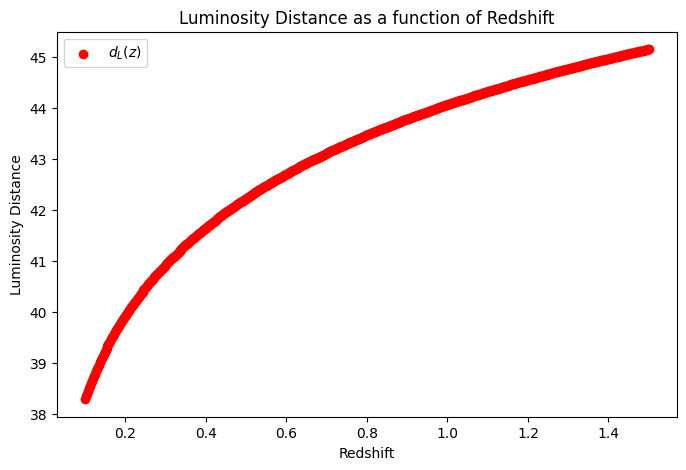

In [143]:
dLs_2 = [dL_modulus(z, h, omega_m, omega_l) for z in zs]

#The plot
plt.figure(figsize=(8, 5))
plt.scatter(zs, dLs_2, label=r'$d_L(z)$', color='red')
plt.xlabel(r'Redshift')
plt.ylabel(r'Luminosity Distance')
plt.title('Luminosity Distance as a function of Redshift')
plt.legend()
plt.show()

## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [144]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Read in data as numpy array.
# Format is [name, redshift, magnitude, magnitude error, and another number?]
data = np.genfromtxt(dataloc)

# Print the first line as an example. (Note that genfromtxt turns the names into 'Not A Number')
print(data[0])

[           nan 2.84880000e-02 3.53465834e+01 2.23905933e-01
 1.28418942e-01]


In [145]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs2 = data.T[1] # redshift, I changed the name as suggested by Sophia, so I don't confuse data set with the other zs
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus

In [146]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once
import scipy.integrate as integrate

# luminosity distance in pc
dpc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
dMpc = dpc / 10.**6

# and the error on that distance:
dMe = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

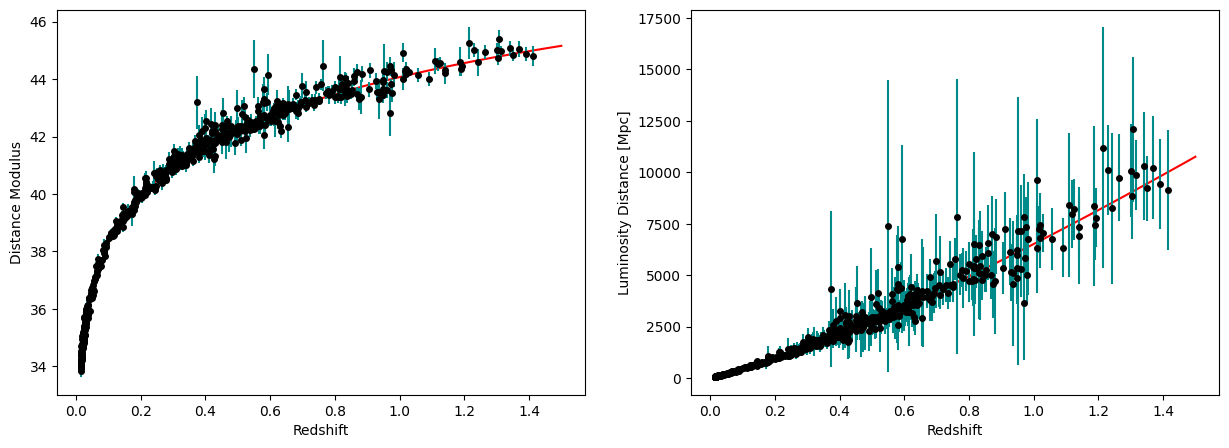

In [147]:
plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
'''I tried to use plt.scatter first, but it completely destroyed the whole code. So now I use plot instead.'''
plt.plot(zs, dLs_2, label=r'$d_L(z)$', color='red')
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs2, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.plot(zs, dLs, label=r'$d_L(z)$', color='red')
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs2, dMpc, yerr=dMe, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.show()

## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [157]:
""" I did this part with the help of ChatGPT, and also asked other student to explain the theory.
    Ai explained me what exactly the MCMC does, and what function I need to run it. 
    Actually, I spent most of the time trying to understand the theory.
    But after that the process of code-writing was mostly on my own,
    with just the help from Ai with debugging and improvement suggestions.
    So now it's more like a big mix of code. """

import numpy as np
import matplotlib.pyplot as plt

# Prior Function as was described in theory cell
def prior(h, omega_m, omega_l):
    
    # Checks if the parameters are within the allowed ranges
    if 0.5 < h < 0.9 and 0.0 < omega_m < 1.0 and 0.0 < omega_l < 1.0:
        return 1.0
    else:
        return 0.0

def likelihood(h, omega_m, omega_l, zs, mus, mu_err):  # made with the help from Chat GPT
    ''' Computes the likelihood for a given set of cosmological parameters,
        the formula taken from the theory cell above. '''

    chi2_val = 0.0  # chi^2 accumulator
    
    for z, mu_obs, err in zip(zs, mus, mu_err):
        mu_theor = dL_modulus(z, h, omega_m, omega_l)  # dL_modulus was defined before.
        chi2_val += ((mu_theor - mu_obs) ** 2) / (err ** 2)
    return np.exp(-chi2_val / 2.0)

# MCMC Function (Metropolis–Hastings)
def mcmc(number_of_steps, initial_parameters, step_sizes, zs, mus, mu_err):
    ''' Runs an MCMC chain using the Metropolis–Hastings algorithm. '''
    
    chain = []  # Where I store the entries

    h_current, omega_m_current, omega_l_current = initial_parameters
    
    # Likelihood for the current parameters
    current_like = likelihood(h_current, omega_m_current, omega_l_current, zs, mus, mu_err)
    chain.append((h_current, omega_m_current, omega_l_current))
    
    # Loops over number of MCMC steps I choose in the main
    for i in range(number_of_steps):
        h_prop = np.random.normal(h_current, step_sizes[0])
        omega_m_prop = np.random.normal(omega_m_current, step_sizes[1])
        omega_l_prop = np.random.normal(omega_l_current, step_sizes[2])

        # Checks that the proposed parameters are allowed by the prior; if not, rejects them
        if prior(h_prop, omega_m_prop, omega_l_prop) == 0.0:
            chain.append((h_current, omega_m_current, omega_l_current))
            continue
        
        # Likelihood for the proposed parameters
        prop_like = likelihood(h_prop, omega_m_prop, omega_l_prop, zs, mus, mu_err)
        
        ''' This segment calculates the acceptance probability (ratio of likelihoods).
            It was advised by Chat GPT to use this '''
        acceptance_prob = prop_like / current_like
        if np.random.rand() < acceptance_prob:
            h_current, omega_m_current, omega_l_current = h_prop, omega_m_prop, omega_l_prop
            current_like = prop_like 
        
        chain.append((h_current, omega_m_current, omega_l_current))
    
    return chain

""" Main body: Data generation to try and run the function. """

# Generating redshift values; here using 580 points between 0.01 and 1.5
zs = np.linspace(0.01, 1.5, 580) # Different zs here, do not confuse with zs2

h_true = 0.7
omega_m_true = 0.3
omega_l_true = 0.7

# Generating true distance moduli using the provided dL_modulus function.
''' I assumed a constant observational error of 0.2 magnitudes, suggested by ChatGPT o3.
    Also added Gaussian noise to the true values to get observed data. '''
mu_true = np.array([dL_modulus(z, h_true, omega_m_true, omega_l_true) for z in zs])
mu_err = 0.2 * np.ones_like(mu_true)
mus = mu_true + np.random.normal(0, mu_err, size=mu_true.shape)

# MCMC Parameters
initial_parameters = (0.65, 0.25, 0.75)  # h, omega_m, omega_l
step_sizes = (0.01, 0.01, 0.01)  # step sizes for h, omega_m and omega_l
n_steps = 1000
chain = mcmc(n_steps, initial_parameters, step_sizes, zs, mus, mu_err)
chain = np.array(chain) 

''' As I understood, it's used to adjust the model,
    basically gets rid of irrelevant results. '''
burn_in = int(0.2 * n_steps) # Burn-in period for mcmc

print("Iteration iD  Omega_m   Omega_L     h     Omega_k")

''' Only some of the results are shown in the output, 
    I did it mostly to check whether the values looked correctly. '''
for idx, (h_val, omega_m_val, omega_l_val) in zip(range(burn_in, chain.shape[0], 100), chain[burn_in::100]): # Only show each 100th data point 
    # Sophia told me that we need to get the value for Omega_k based on our results for the other two
    omega_k = 1 - omega_m_val - omega_l_val
    # Suggested by ChatGPT o3 to make the output look like in the example
    print(     f"{idx:9d}   {omega_m_val:7.3f}   {omega_l_val:7.3f}     {h_val*100:5.1f}   {omega_k:7.3f}") 

''' Fran explained me how to build the last graph, and that I need best-fit for it.
    For this segment, I also used advice from ChatGPT o3 mini.
    It runs MCMC for cosmological parameters, discarding early burn-in samples.
    Selects best-fit values via maximum likelihood for plotting. '''
burned_chain = chain[burn_in:]
likelihoods = [likelihood(h, omega_m, omega_l, zs, mus, mu_err) for h, omega_m, omega_l in burned_chain]
best_index = np.argmax(likelihoods)
best_h, best_omega_m, best_omega_l = burned_chain[best_index]
best_omega_k = 1 - best_omega_m - best_omega_l

# Printing values to check whether it amkes sense:
''' print("\nBest-fit values from MCMC:")
print(f"h: {best_h:.3f}")
print(f"Omega_m: {best_omega_m:.3f}")
print(f"Omega_l: {best_omega_l:.3f}")
print(f"Omega_k: {best_omega_k:.3f}") '''

Iteration iD  Omega_m   Omega_L     h     Omega_k
      200     0.297     0.708      69.7    -0.004
      300     0.293     0.715      70.1    -0.007
      400     0.301     0.761      70.8    -0.062
      500     0.296     0.825      71.1    -0.121
      600     0.339     0.751      69.7    -0.090
      700     0.293     0.745      70.8    -0.037
      800     0.323     0.743      70.6    -0.066
      900     0.283     0.758      71.0    -0.041
     1000     0.301     0.764      70.6    -0.065

Best-fit values from MCMC:
h: 0.705
Omega_m: 0.282
Omega_l: 0.707
Omega_k: 0.011


After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
 ...
`

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

Removed no burn in


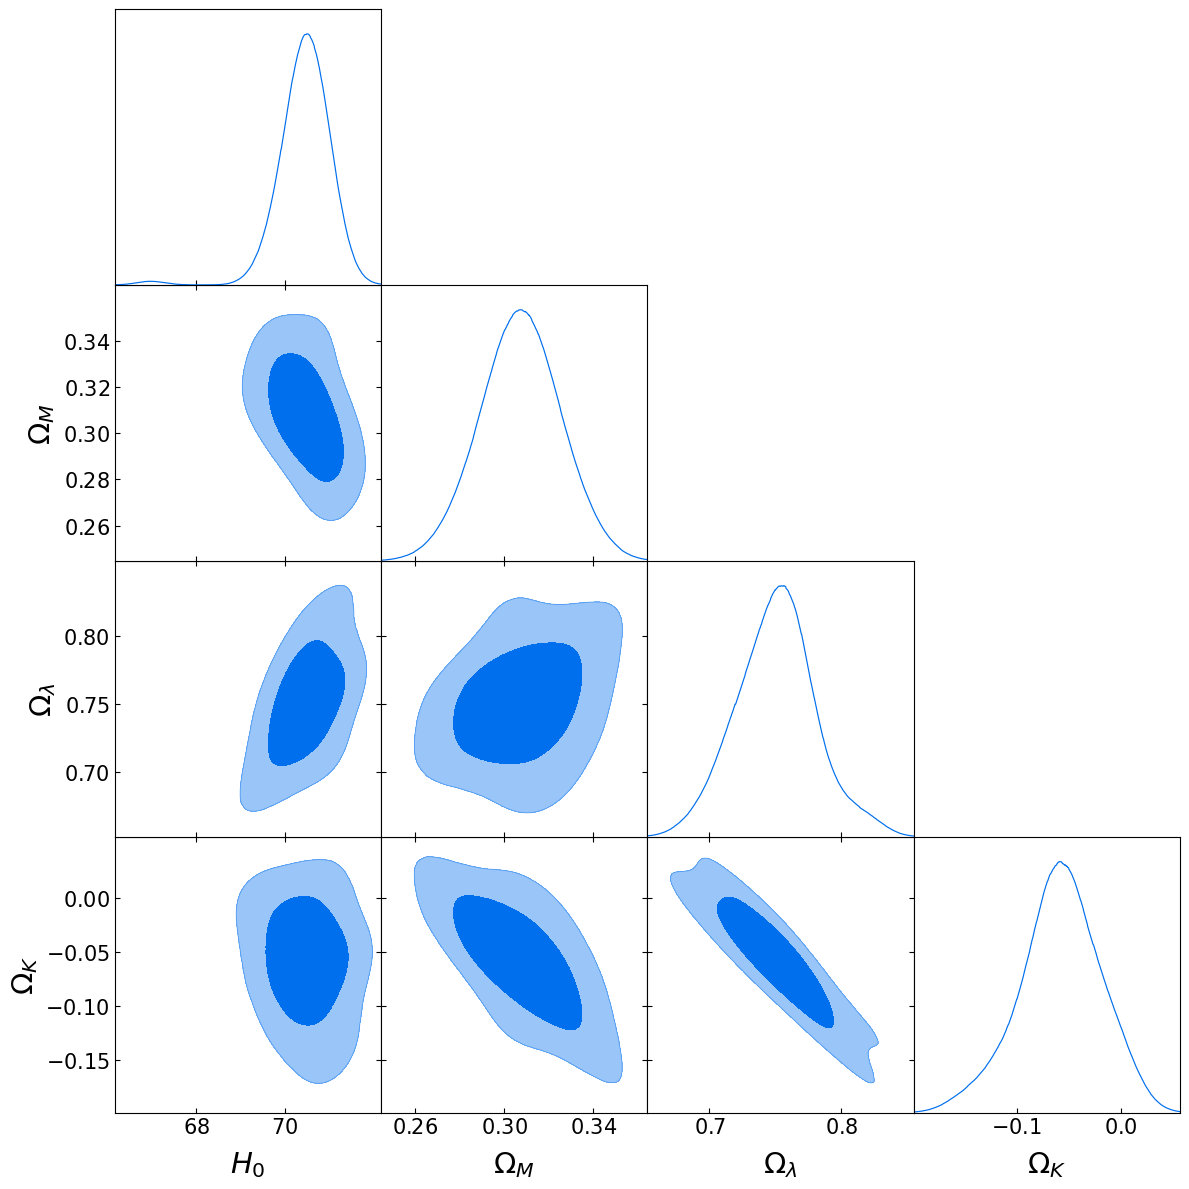

In [158]:
import getdist, IPython
from getdist import plots, MCSamples, loadMCSamples
#print('Version: ',getdist.__version__)
import numpy as np
import pylab
from random import random
from random import gauss
# If you want to use LaTeX in the labels. Not mandatory, but it looks nice ;)
#pylab.rc('text',usetex=True) 

my_length = 1000; 
# Adding values for the parameters from the previous function
par1 = chain[:, 0] * 100
par2 = chain[:, 1]
par3 = chain[:, 2]

par1 = np.array(par1)
par2 = np.array(par2)
par3 = np.array(par3)
par4 = 1 - par2 - par3

my_labels = ['H_0', 'Ω_{M}', 'Ω_λ', 'Ω_{K}']
my_names  = ['H0', 'Ω_M', 'Ω_λ', 'Ω_K']
my_samples = np.array([par1, par2, par3, par4])

my_dim = 4

my_samples = np.transpose(np.reshape(my_samples,(my_dim,int(my_samples.size/my_dim))))
samples1 = MCSamples(samples = my_samples, labels = my_labels, names = my_names)

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled = True)

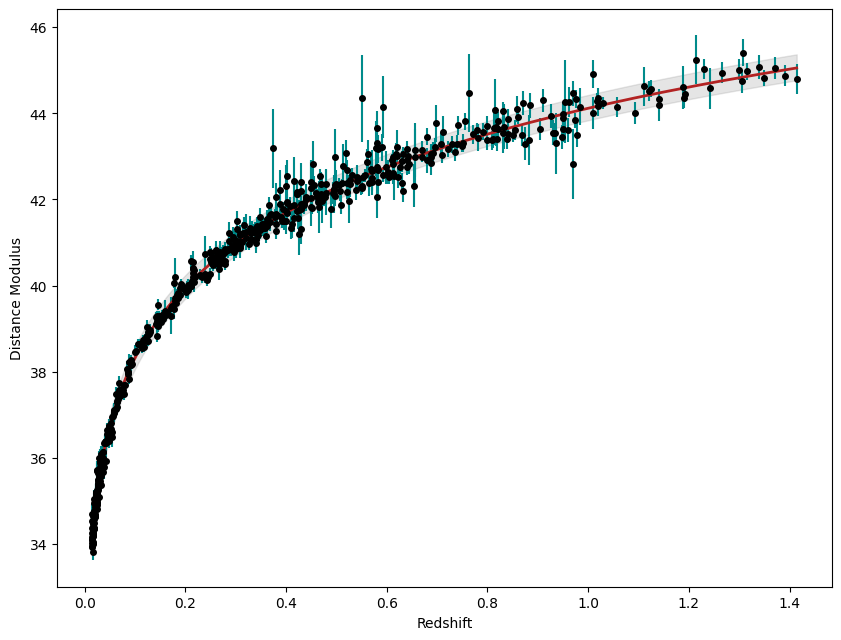

In [159]:
# example of theoretical curves
SPEED_OF_LIGHT = 299792.458 # in km/s

# Still need to add Omega_k!
def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL), 0., z)[0]

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))
                 
zsort = sorted(zs2) # I initially confused it with zs, spent some time dealing with this
d_best_fit, d_min, d_max = [], [], []

H_0_best = best_h * 100

# YOUR RESULTS GO HERE!
for z in zsort:
    d_best_fit.append(theor_distance_modulus(z, H_0_best, best_omega_m, best_omega_l))
    d_min.append(theor_distance_modulus(z, H_0_best + 5, best_omega_m + 0.05, best_omega_l + 0.05))
    d_max.append(theor_distance_modulus(z, H_0_best - 5, best_omega_m - 0.05, best_omega_l - 0.05))
    
plt.subplots(figsize=(10, 7.5))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs2, dist_mod, yerr=err_dist_mod,\
             fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, d_best_fit, color='firebrick',linewidth=2.)
plt.fill_between(zsort, d_min, d_max, color='grey', alpha=.2)
plt.show()